## Dask Option

In [1]:
from dask.distributed import Client, LocalCluster
import awkward as ak
import uproot
import dask_awkward as dak
import dask.dataframe as dd
import matplotlib.pyplot as plt
import glob

# --- connect to a local or remote Dask cluster ---------------------------
cluster = LocalCluster(n_workers=16,
                       threads_per_worker=1)   # tweak to your node
client  = Client(cluster)

patterns = [
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/qcd*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/wjets*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/zjets*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/st_*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/tt*_2018*/**/*.root",
]

files = [f for pat in patterns for f in glob.glob(pat, recursive=True)]
if not files:
    raise RuntimeError("No ROOT files matched any pattern – check the path or mounts.")


files_as_dict = {f: "Events" for f in files}

branches = ["vtx_PART_338_epoch_6", 
            "SDVSecVtx_mass",
            "SDVSecVtx_Lxy",
            "SDVSecVtx_LxySig",
            "SDVSecVtx_pAngle",
            "SDVSecVtx_nTracks",
            "SDVSecVtx_sum_tkW",
            "SDVSecVtx_ndof",
            "SDVSecVtx_charge"]           # ← replace with real branch names

lazy = uproot.dask(files_as_dict, 
                   filter_name=branches, 
                   library="ak",
                   open_files=False)  # dask‑awkward

/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [ ]:
# --- zip & flatten *lazily* (no data pulled yet) ------------------------
rec      = dak.zip({k: lazy[k] for k in branches})        # record array
rec['Max_vtx_PART_338_epoch_6'] = ak.max(rec['vtx_PART_338_epoch_6'], axis=1)  # add a new field
rec_flat = ak.flatten(rec, axis=1)                        # flattened record

# --- turn into a Dask DataFrame and persist partitions ------------------
ddf = dak.to_dataframe(rec_flat)
ddf = ddf.persist()           # keeps chunks on the workers’ memory

# now use the ddf exactly like a pandas DataFrame, e.g.
corr = ddf.corr()

TypeError: cannot compare unknown lengths against known values

In [4]:
corr.visualize(filename='corr.svg')

In [5]:
corr_res = corr.compute()
print(corr_res)

# --- plot (small result, back on driver) ---------------------------------
# f = plt.figure(figsize=(8,6))
# plt.matshow(corr, fignum=f.number)
# plt.xticks(range(len(corr)), corr.columns, rotation=45)
# plt.yticks(range(len(corr)), corr.columns)
# plt.colorbar(); plt.tight_layout(); plt.show()


/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1

                      vtx_PART_338_epoch_6  SDVSecVtx_mass  SDVSecVtx_Lxy  \
vtx_PART_338_epoch_6              1.000000        0.095959      -0.146384   
SDVSecVtx_mass                    0.095959        1.000000      -0.150746   
SDVSecVtx_Lxy                    -0.146384       -0.150746       1.000000   
SDVSecVtx_LxySig                 -0.033624       -0.086418       0.302852   
SDVSecVtx_pAngle                 -0.080736        0.163105      -0.256739   
SDVSecVtx_nTracks                 0.345712        0.304589      -0.093717   
SDVSecVtx_sum_tkW                 0.330501        0.282311      -0.068961   
SDVSecVtx_ndof                    0.330714        0.282447      -0.069325   
SDVSecVtx_charge                  0.002072       -0.006137       0.029898   

                      SDVSecVtx_LxySig  SDVSecVtx_pAngle  SDVSecVtx_nTracks  \
vtx_PART_338_epoch_6         -0.033624         -0.080736           0.345712   
SDVSecVtx_mass               -0.086418          0.163105           0.30

In [7]:
corr_res

vtx_PART_338_epoch_6  SDVSecVtx_mass  SDVSecVtx_Lxy  \
vtx_PART_338_epoch_6              1.000000        0.095959      -0.146384   
SDVSecVtx_mass                    0.095959        1.000000      -0.150746   
SDVSecVtx_Lxy                    -0.146384       -0.150746       1.000000   
SDVSecVtx_LxySig                 -0.033624       -0.086418       0.302852   
SDVSecVtx_pAngle                 -0.080736        0.163105      -0.256739   
SDVSecVtx_nTracks                 0.345712        0.304589      -0.093717   
SDVSecVtx_sum_tkW                 0.330501        0.282311      -0.068961   
SDVSecVtx_ndof                    0.330714        0.282447      -0.069325   
SDVSecVtx_charge                  0.002072       -0.006137       0.029898   

                      SDVSecVtx_LxySig  SDVSecVtx_pAngle  SDVSecVtx_nTracks  \
vtx_PART_338_epoch_6         -0.033624         -0.080736           0.345712   
SDVSecVtx_mass               -0.086418          0.163105           0.304589   
SDVSecVtx_Lxy                 0.302852         -0.256739          -0.093717   
SDVSecVtx_LxySig              1.000000         -0.146570          -0.005501   
SDVSecVtx_pAngle             -0.146570          1.000000          -0.061533   
SDVSecVtx_nTracks            -0.005501         -0.061533           1.000000   
SDVSecVtx_sum_tkW             0.003955         -0.069951           0.978454   
SDVSecVtx_ndof                0.003887         -0.069887           0.978615   
SDVSecVtx_charge              0.040269         -0.008383           0.002437   

                      SDVSecVtx_sum_tkW  SDVSecVtx_ndof  SDVSecVtx_charge  
vtx_PART_338_epoch_6           0.330501        0.330714          0.002072  
SDVSecVtx_mass                 0.282311        0.282447         -0.006137  
SDVSecVtx_Lxy                 -0.068961       -0.069325          0.029898  
SDVSecVtx_LxySig               0.003955        0.003887          0.040269  
SDVSecVtx_pAngle              -0.069951       -0.069887         -0.008383  
SDVSecVtx_nTracks              0.978454        0.978615          0.002437  
SDVSecVtx_sum_tkW              1.000000        0.999993          0.004080  
SDVSecVtx_ndof                 0.999993        1.000000          0.004064  
SDVSecVtx_charge               0.004080        0.004064          1.000000

/tmp/ipykernel_57228/2692666570.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.colorbar(); plt.tight_layout(); plt.show()


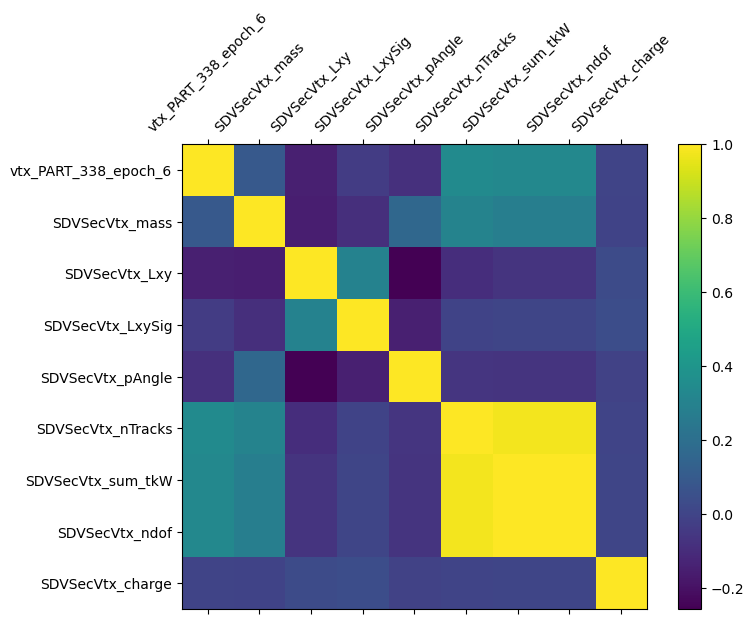

In [9]:
# --- plot (small result, back on driver) ---------------------------------
f = plt.figure(figsize=(8,6))
plt.matshow(corr_res, fignum=f.number)
plt.xticks(range(len(corr_res)), corr_res.columns, rotation=45)
plt.yticks(range(len(corr_res)), corr_res.columns)
plt.colorbar(); plt.tight_layout(); plt.show()

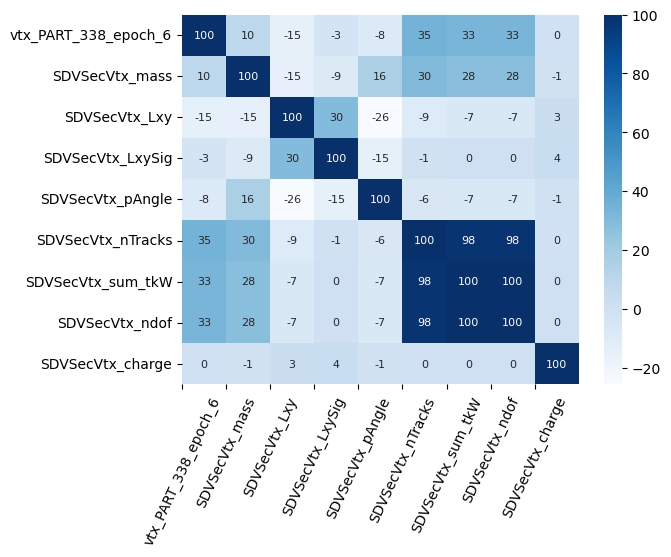

In [44]:
import seaborn as sns
corr_res_scaled = corr_res * 100
s = sns.heatmap(corr_res_scaled, annot=True,cmap='Blues', fmt=".0f", annot_kws={"size": 8})
plt.xticks(range(len(corr_res_scaled)), corr_res_scaled.columns, rotation=65)
plt.show()

### Awkward DEBUG 

In [53]:
from dask.distributed import Client, LocalCluster
import awkward as ak
import uproot
import dask_awkward as dak
import dask.dataframe as dd
import matplotlib.pyplot as plt
import glob

# --- connect to a local or remote Dask cluster ---------------------------
cluster = LocalCluster(n_workers=16,
                       threads_per_worker=1)   # tweak to your node
client  = Client(cluster)

patterns = [
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/qcd*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/wjets*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/zjets*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/st_*_2018*/**/*.root",
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/tt*_2018*/**/*.root",
]

files = [f for pat in patterns for f in glob.glob(pat, recursive=True)]
if not files:
    raise RuntimeError("No ROOT files matched any pattern - check the path or mounts.")


files_as_dict = {f: "Events" for f in files[:1]}

ev_branches = ["MET_pt",]
sv_branches = ["vtx_PART_338_epoch_6",]
branches = [*ev_branches, *sv_branches]

# branches = ["vtx_PART_338_epoch_6", 
#             "MET_pt"
            # "SDVSecVtx_mass",
            # "SDVSecVtx_Lxy",
            # "SDVSecVtx_LxySig",
            # "SDVSecVtx_pAngle",
            # "SDVSecVtx_nTracks",
            # "SDVSecVtx_sum_tkW",
            # "SDVSecVtx_ndof",
            # "SDVSecVtx_charge"
#             ]           # ← replace with real branch names

lazy = uproot.dask(files_as_dict, 
                   filter_name=branches, 
                   library="ak",
                   open_files=False)  # dask‑awkward

/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38293 instead
  warnings.warn(


In [ ]:
rec = dak.copy(lazy)
rec['Max_vtx_PART_338_epoch_6'] = ak.max(rec['vtx_PART_338_epoch_6'], axis=1)  # add a new field
ev_branches.append('Max_vtx_PART_338_epoch_6')
rec = rec[[k for k in ev_branches]]  # keep only the ev branches

ddf = dak.to_dataframe(rec)
ddf[ddf.]

ddf = ddf.persist()           # keeps chunks on the workers’ memory

# now use the ddf exactly like a pandas DataFrame, e.g.
corr = ddf.corr()

corr_res = corr.compute()

/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1

In [ ]:
# corr_res = corr.compute()

/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


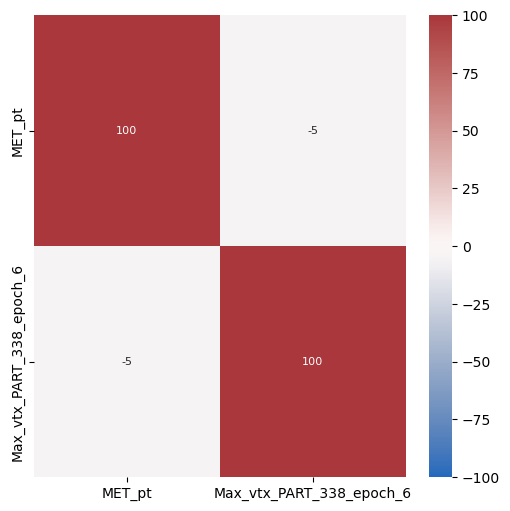

In [52]:
import seaborn as sns
corr_res_scaled = corr_res * 100
plt.figure(figsize=(6,6))
s = sns.heatmap(corr_res_scaled, annot=True,cmap='vlag', fmt=".0f", annot_kws={"size": 8}, vmin=-100, vmax=100)
plt.show()

# Signal

In [142]:
from dask.distributed import Client, LocalCluster
import awkward as ak
import uproot
import dask_awkward as dak
import dask.dataframe as dd
import matplotlib.pyplot as plt
import glob
import fnmatch
import numpy as np

# --- connect to a local or remote Dask cluster ---------------------------
cluster = LocalCluster(n_workers=16,
                       threads_per_worker=1)   # tweak to your node
client  = Client(cluster)

patterns = [
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/stop_M1000*_2018*/**/*.root",
]

files = [f for pat in patterns for f in glob.glob(pat, recursive=True)]
if not files:
    raise RuntimeError("No ROOT files matched any pattern - check the path or mounts.")


files_as_dict = {f: "Events" for f in files}

# ----------------------------------------------------------------------------
# Open one representative file to resolve branch names
sample_file = next(iter(files_as_dict))
with uproot.open(sample_file)["Events"] as tree:
    available_branches = tree.keys()


ev_branches =  ["MET*", "nSDVSecVtx"]
sv_branches = ["vtx_PART_338_epoch_*", "SDVSecVtx*", ]
id_branches = ["SDVIdxLUT*"]
tk_branches = ["SDVTrack*"]
patterns = ev_branches + sv_branches + tk_branches


branches = {}
for pattern in ev_branches:
    branches['ev'] = fnmatch.filter(available_branches, pattern)
for pattern in sv_branches:
    branches['sv'] = fnmatch.filter(available_branches, pattern)
for pattern in id_branches:
    branches['id'] = fnmatch.filter(available_branches, pattern)
for pattern in tk_branches:
    branches['tk'] = fnmatch.filter(available_branches, pattern)

# for key in branches:
#     print(key)
#     print(branches[key])
# ----------------------------------------------------------------------------


files_as_dict = {'/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/stop_M1000_985_ct20_2018/output/out_NANOAODSIMoutput_2.root': 'Events'}

lazy = uproot.dask(files_as_dict, 
                   filter_name=list(branches.values()), 
                   library="ak",
                   open_files=False)  # dask‑awkward


# ----------------
from numba import njit
@njit
def deepTable(tkBranch, trIdx, svIdx, n_sv, builder):
    """
    Takes the track level branch and converts its shape
    from: (nEvent * var * float32) to (nEvent * var * var * float32)
    representing the association of each tk with sv.

    svIdx: [[0, 0, 1, 1,  2, 2,  3,  3, ...], ...]
    trIdx: [[1, 3, 3, 28, 7, 8, 10, 11, ...], ...]
    n_sv:  [4, 0, 6, 1, 1, 7, ...]
    """
    # at event level depth already
    # every element added are at event level depth
    for ev in range(len(n_sv)):                   # 
        builder.begin_list()                      # adding sv level depth
        for sv in range(n_sv[ev]):                # for each vtx ... 
            builder.begin_list()
            for i2, col in enumerate(svIdx[ev]):  # getting an svIdx from the svIdxs for that event
                if col == sv:                     # if the same svIdx 
                    builder.append(tkBranch[ev][trIdx[ev][i2]])
            builder.end_list()
        builder.end_list()

# def deepTable_lazy(partition, trIdx, svIdx, n_sv):
#     # Bail out early during the optimizer’s dry run
#     if partition.type._length is ak._nplikes.shape.unknown_length:
#         return ak.Array([[[np.float32(0.0)]]]) # ak.Array([[[]]])           # any empty array with the right depth
#     builder = ak.ArrayBuilder()
#     deepTable(partition, trIdx, svIdx, n_sv, builder)
#     return builder.snapshot()  # here it's fine; only 1 partition at a time

def deepTable_lazy(partition, trIdx, svIdx, n_sv):
    # 1) Short‑circuit the optimizer’s typetracer pass
    if partition.type._length is ak._nplikes.shape.unknown_length:
        return meta                # the empty array you created earlier

    # 2) Turn every buffer into a real NumPy array
    partition = ak.materialize(partition)
    trIdx     = ak.materialize(trIdx)
    svIdx     = ak.materialize(svIdx)
    n_sv      = ak.materialize(n_sv)

    # 3) Run the jitted kernel
    builder = ak.ArrayBuilder()
    deepTable(partition, trIdx, svIdx, n_sv, builder)
    return builder.snapshot()

deepTable_return_shape = ak.Array([[[np.float32(0.0)]]])
meta = ak.typetracer.typetracer_from_form(deepTable_return_shape.layout.form)

for tk in branches['tk']:
    lazy[tk] = lazy[tk].map_partitions(
        deepTable_lazy,
        lazy['SDVIdxLUT_TrackIdx'],
        lazy['SDVIdxLUT_SecVtxIdx'],
        lazy['nSDVSecVtx'],
        meta=meta
    )
# -----------------------------

template = lazy[branches['sv'][0]]                                      # first sv branch as template to broadcast
broadcasted = {name: dak.broadcast_arrays(lazy[name], template)[0]
               for name in branches['ev']}


ev_sv_df = dak.zip({**broadcasted, **{k: lazy[k] for k in branches['sv']}})        # (n_ev, n_sv)
ev_sv_flat_df = dak.flatten(ev_sv_df)                                                   # (n_ev x n_sv)

tk_semi_flat = {name: ak.flatten(lazy[name]) for name in (branches['tk'])}     # (n_ev x n_sv, n_tk)
tk_semi_flat_df = dak.zip(tk_semi_flat)                                              

# ev_sv_flat_df is automatically broadcasted!
zipped = dak.zip(
    {field: ev_sv_flat_df[field] for field in ev_sv_flat_df.fields} |
    {field: tk_semi_flat_df[field] for field in tk_semi_flat_df.fields})            # (n_ev x n_sv, n_tk)

zipped_flat = dak.flatten(zipped)
ddf = dak.to_dataframe(zipped_flat)
corr = ddf.corr()

/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45509 instead
  warnings.warn(


In [139]:
corr_res = corr.compute()

2025-07-28 14:43:18,408 - distributed.worker - ERROR - Compute Failed
Key:       ('to-dataframe-2b1fcc81c67452ec1c7da6462b1d135f', 0)
State:     executing
Function:  subgraph_callable-e3583f79223287f49337215417b6a75b
args:      ('nSDVSecVtx', 'SDVSecVtx_y', 'SDVSecVtx_mass', 'SDVSecVtx_pt', 'SDVSecVtx_dlenSig', 'SDVSecVtx_LxySig', 'SDVSecVtx_L_phi', 'SDVSecVtx_chi2', 'SDVSecVtx_ndof', 'SDVSecVtx_tracksSize', 'SDVSecVtx_charge', 'SDVSecVtx_matchedLLPDist_bydist', 'SDVSecVtx_matchedLLPnDau_bydau', 'SDVTrack_pfRelIso03_all', 'SDVTrack_dr03TkSumPt', 'SDVTrack_eta', 'SDVTrack_pt', 'SDVTrack_dz', 'SDVTrack_phiError', 'SDVTrack_dxyError', 'SDVTrack_validFraction', 'SDVTrack_isHighPurity', 'SDVTrack_numberOfLostHits', 'SDVTrack_GenPartIdx', 'SDVSecVtx_x', 'SDVSecVtx_energy', 'SDVSecVtx_Lxy', 'SDVSecVtx_L_eta', 'SDVSecVtx_sum_tkW', 'SDVSecVtx_ngoodTrack', 'SDVSecVtx_matchedLLPIdx_bydist', 'SDVTrack_normalizedChi2', 'SDVTrack_dxy', 'SDVTrack_ptError', 'SDVTrack_charge', 'SDVTrack_algo', 'SDVSecV

AttributeError: 'PlaceholderArray' object has no attribute 'ctypes'

Object `ak.compute` not found.


In [ ]:
import seaborn as sns
corr_res_scaled = corr_res * 100
plt.figure(figsize=(24,24), dpi=200)
s = sns.heatmap(corr_res_scaled, annot=True,cmap='vlag', fmt=".0f", annot_kws={"size": 8}, vmin=-100, vmax=100)
plt.xticks(range(len(corr_res_scaled)), corr_res_scaled.columns, rotation=80)
plt.show()

: 

In [122]:
ak.Array([[[]]]) 

<Array [[[]]] type='1 * var * var * unknown'>

### Working version in-core

In [84]:
from dask.distributed import Client, LocalCluster
import awkward as ak
import uproot
import dask_awkward as dak
import dask.dataframe as dd
import matplotlib.pyplot as plt
import glob
import fnmatch
import numpy as np

# --- connect to a local or remote Dask cluster ---------------------------
cluster = LocalCluster(n_workers=16,
                       threads_per_worker=1)   # tweak to your node
client  = Client(cluster)

patterns = [
    "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/stop_M1000*_2018*/**/*.root",
]

files = [f for pat in patterns for f in glob.glob(pat, recursive=True)]
if not files:
    raise RuntimeError("No ROOT files matched any pattern - check the path or mounts.")


files_as_dict = {f: "Events" for f in files}

# ----------------------------------------------------------------------------
# Open one representative file to resolve branch names
sample_file = next(iter(files_as_dict))
with uproot.open(sample_file)["Events"] as tree:
    available_branches = tree.keys()


ev_branches =  ["MET*", "nSDVSec*"]
sv_branches = ["vtx_PART_338_epoch_*", "SDVSecVtx*", ]
id_branches = ["SDVIdxLUT*"]
tk_branches = ["SDVTrack*"]
patterns = ev_branches + sv_branches + tk_branches


branches = {'ev': [], 'sv': [], 'id': [], 'tk': []}
for pattern in ev_branches:
    branches['ev'].extend(fnmatch.filter(available_branches, pattern))
for pattern in sv_branches:
    branches['sv'].extend(fnmatch.filter(available_branches, pattern))
for pattern in id_branches:
    branches['id'].extend(fnmatch.filter(available_branches, pattern))
for pattern in tk_branches:
    branches['tk'].extend(fnmatch.filter(available_branches, pattern))

# ----------------------------------------------------------------------------
for key in branches:
    print(key)
    print(branches[key])
# ----------------------------------------------------------------------------


# files_as_dict = {'/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/stop_M1000_985_ct20_2018/output/out_NANOAODSIMoutput_2.root': 'Events'}

lazy = uproot.dask(files_as_dict, 
                   filter_name=list(branches.values()), 
                   library="ak",
                   open_files=False)  # dask‑awkward


# ----------------
from numba import njit
@njit
def deepTable(tkBranch, trIdx, svIdx, n_sv, builder):
    """
    Takes the track level branch and converts its shape
    from: (nEvent * var * float32) to (nEvent * var * var * float32)
    representing the association of each tk with sv.

    svIdx: [[0, 0, 1, 1,  2, 2,  3,  3, ...], ...]
    trIdx: [[1, 3, 3, 28, 7, 8, 10, 11, ...], ...]
    n_sv:  [4, 0, 6, 1, 1, 7, ...]
    """
    # at event level depth already
    # every element added are at event level depth
    for ev in range(len(n_sv)):                   # 
        builder.begin_list()                      # adding sv level depth
        for sv in range(n_sv[ev]):                # for each vtx ... 
            builder.begin_list()
            for i2, col in enumerate(svIdx[ev]):  # getting an svIdx from the svIdxs for that event
                if col == sv:                     # if the same svIdx 
                    builder.append(tkBranch[ev][trIdx[ev][i2]])
            builder.end_list()
        builder.end_list()

def deepTable_lazy(partition, trIdx, svIdx, n_sv):
    builder = ak.ArrayBuilder()
    deepTable(partition, trIdx, svIdx, n_sv, builder)
    return builder.snapshot()  # here it's fine; only 1 partition at a time


lazy = lazy.compute()

/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45818 instead
  warnings.warn(


ev
['MET_MetUnclustEnUpDeltaX', 'MET_MetUnclustEnUpDeltaY', 'MET_covXX', 'MET_covXY', 'MET_covYY', 'MET_phi', 'MET_pt', 'MET_significance', 'MET_sumEt', 'MET_sumPtUnclustered', 'MET_fiducialGenPhi', 'MET_fiducialGenPt', 'nSDVSecVtx']
sv
['vtx_PART_338_epoch_6', 'vtx_PART_338_epoch_7', 'vtx_PART_338_epoch_7', 'SDVSecVtx_x', 'SDVSecVtx_y', 'SDVSecVtx_z', 'SDVSecVtx_mass', 'SDVSecVtx_energy', 'SDVSecVtx_pt', 'SDVSecVtx_dlen', 'SDVSecVtx_dlenSig', 'SDVSecVtx_Lxy', 'SDVSecVtx_LxySig', 'SDVSecVtx_pAngle', 'SDVSecVtx_L_phi', 'SDVSecVtx_L_eta', 'SDVSecVtx_chi2', 'SDVSecVtx_normalizedChi2', 'SDVSecVtx_ndof', 'SDVSecVtx_sum_tkW', 'SDVSecVtx_tracksSize', 'SDVSecVtx_nTracks', 'SDVSecVtx_charge', 'SDVSecVtx_ngoodTrack', 'SDVSecVtx_matchedLLPDist_bydist', 'SDVSecVtx_matchedLLPIdx_bydau', 'SDVSecVtx_matchedLLPnDau_bydau', 'SDVSecVtx_matchedLLPIdx_bydist']
id
['SDVIdxLUT_TrackWeight', 'SDVIdxLUT_SecVtxIdx', 'SDVIdxLUT_TrackIdx']
tk
['SDVTrack_pfRelIso03_all', 'SDVTrack_pfRelIso03_chg', 'SDVTrack_dr03T

In [ ]:
lazy_copy = ak.copy(lazy)

for tk in branches['tk']:
    lazy_copy[tk] = deepTable_lazy(lazy_copy[tk], lazy_copy['SDVIdxLUT_TrackIdx'], lazy_copy['SDVIdxLUT_SecVtxIdx'], lazy_copy['nSDVSecVtx'])

template = lazy_copy[branches['sv'][0]]                                      # first sv branch as template to broadcast
broadcasted = {name: ak.broadcast_arrays(lazy_copy[name], template)[0]
               for name in branches['ev']}


ev_sv_df = ak.zip({**broadcasted, **{k: lazy_copy[k] for k in branches['sv']}})        # (n_ev, n_sv)
ev_sv_flat_df = ak.flatten(ev_sv_df)                                                   # (n_ev x n_sv)

tk_semi_flat = {name: ak.flatten(lazy_copy[name]) for name in (branches['tk'])}     # (n_ev x n_sv, n_tk)
tk_semi_flat_df = ak.zip(tk_semi_flat)                                              

# ev_sv_flat_df is automatically broadcasted!
zipped = ak.zip(
    {field: ev_sv_flat_df[field] for field in ev_sv_flat_df.fields} |
    {field: tk_semi_flat_df[field] for field in tk_semi_flat_df.fields})            # (n_ev x n_sv, n_tk)

zipped_flat = ak.flatten(zipped)
ddf = ak.to_dataframe(zipped_flat)
corr = ddf.corr()

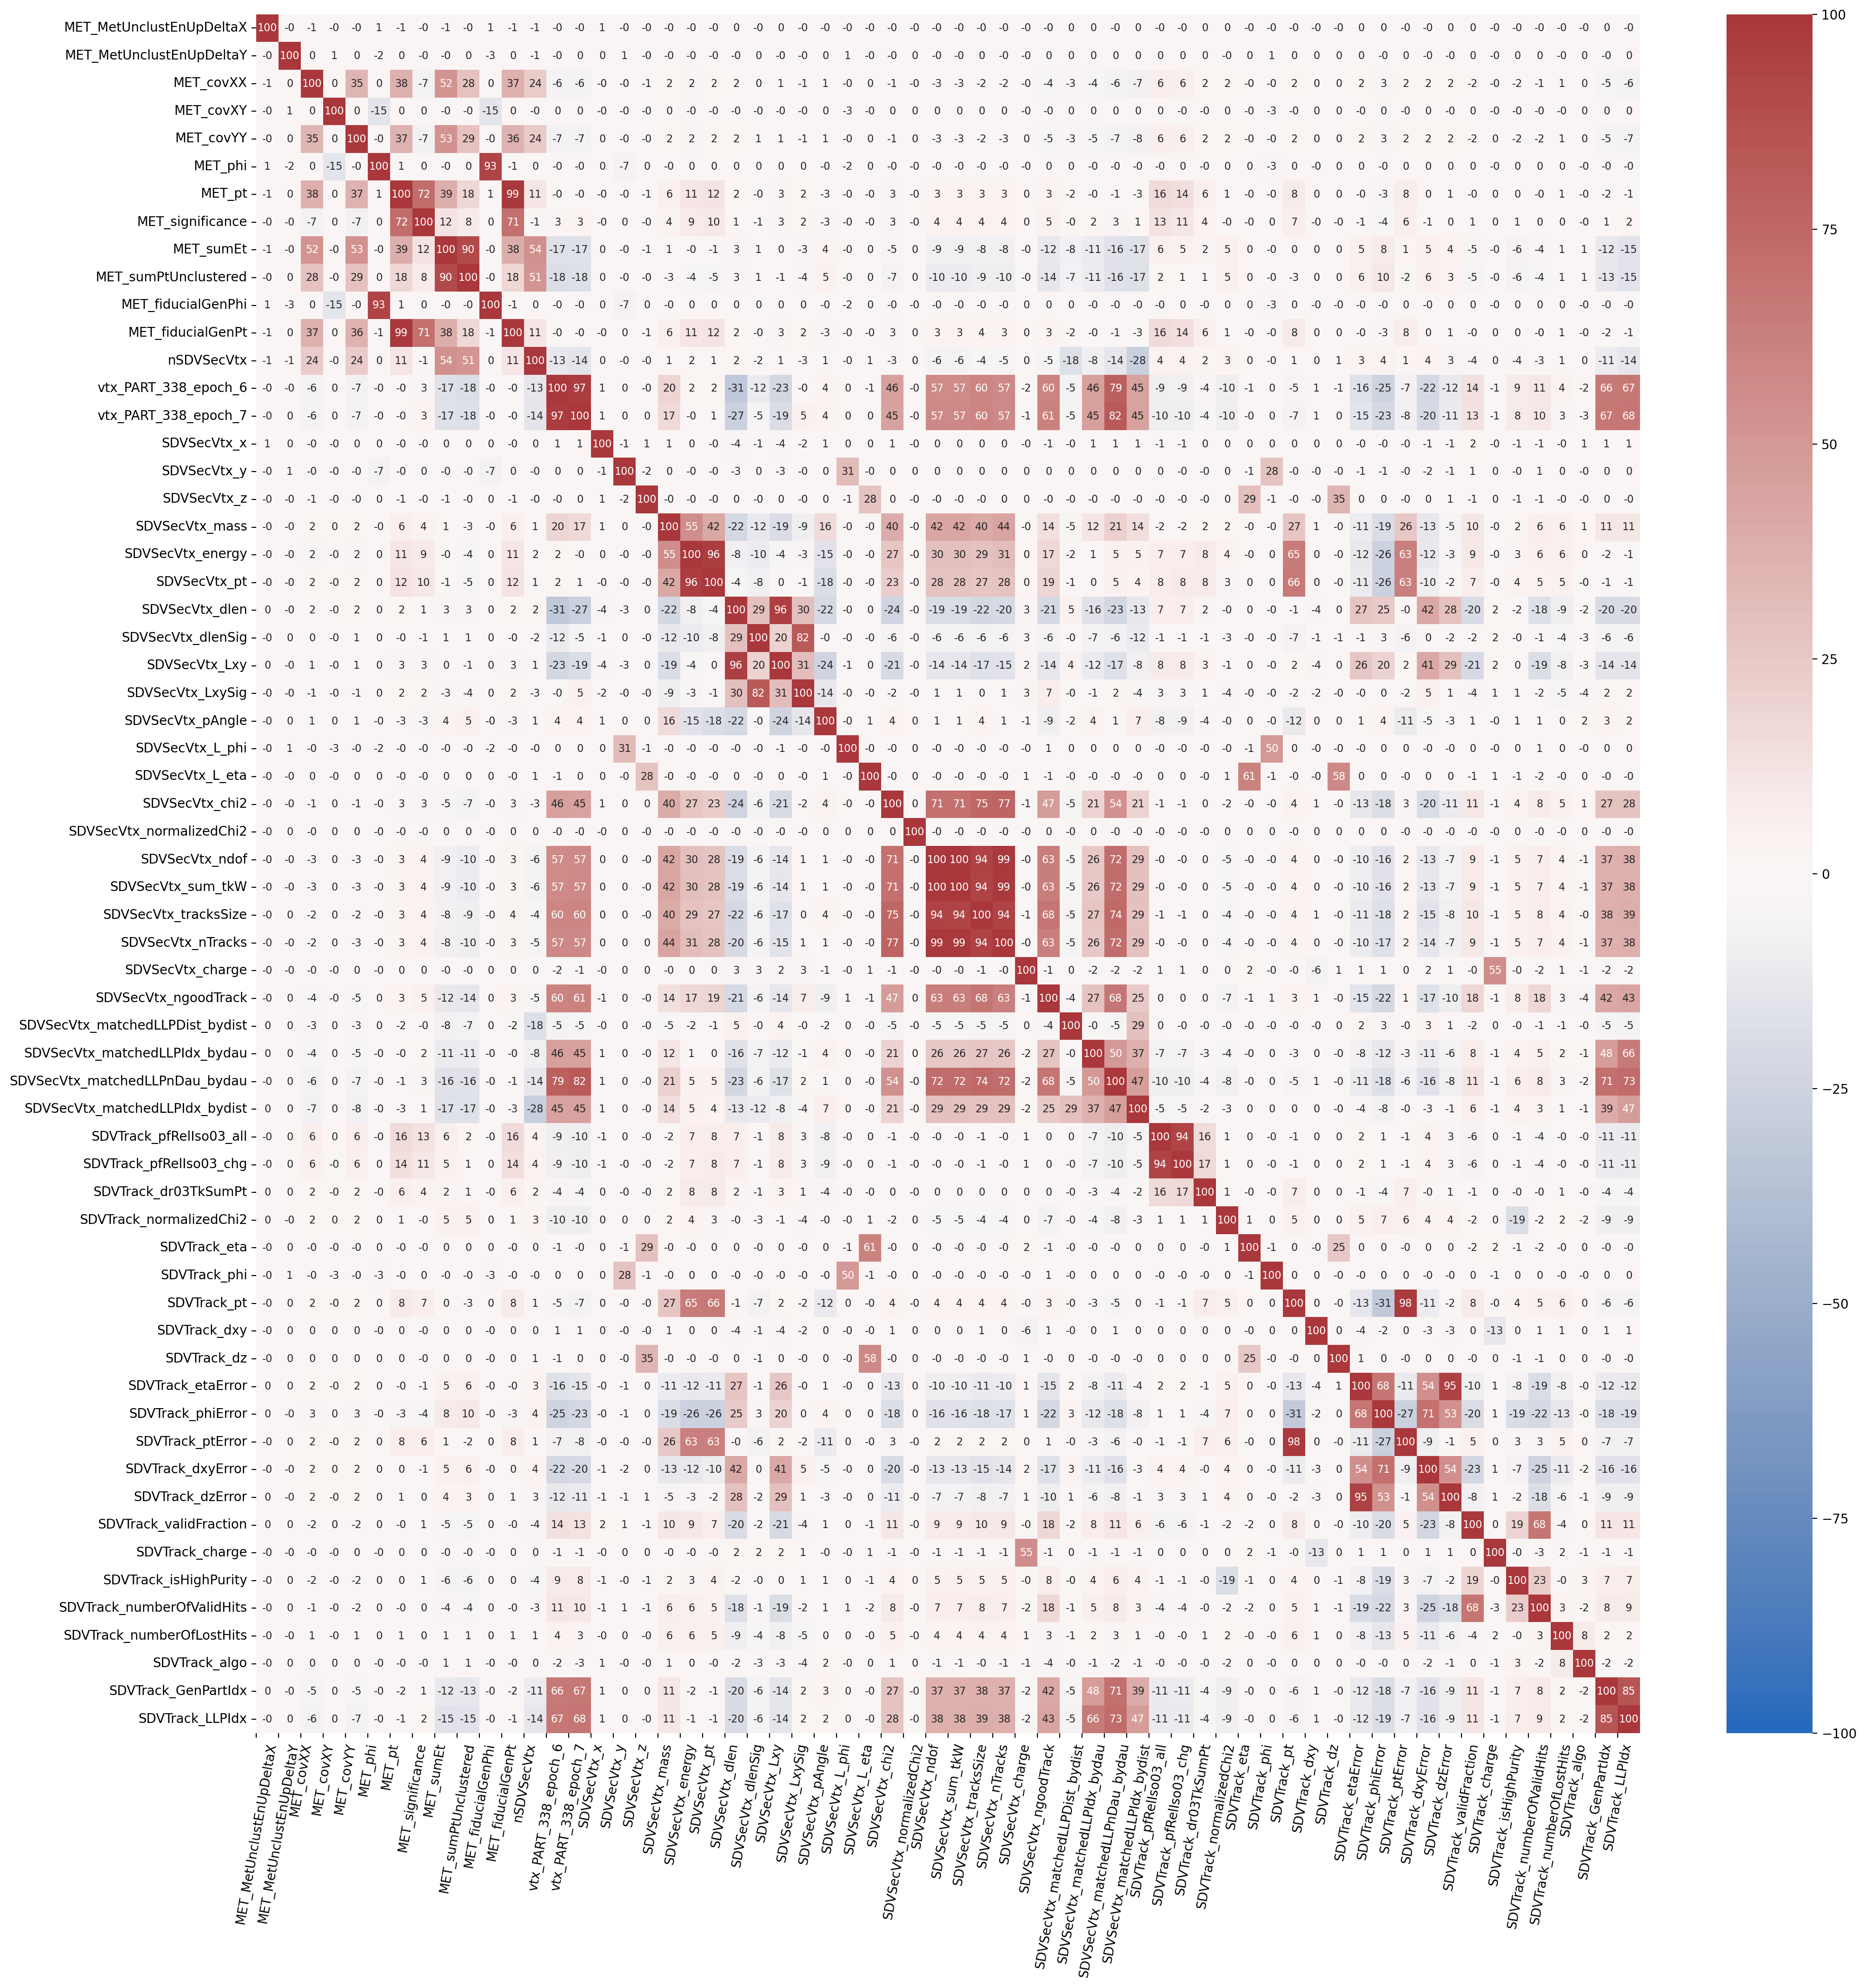

In [94]:
corr_res = corr

import seaborn as sns
corr_res_scaled = corr_res * 100
plt.figure(figsize=(24,24), dpi=200)
s = sns.heatmap(corr_res_scaled, annot=True,cmap='vlag', fmt=".0f", annot_kws={"size": 8}, vmin=-100, vmax=100)
plt.xticks(range(len(corr_res_scaled)), corr_res_scaled.columns, rotation=80)
plt.show()

In [9]:
corr_res = corr.compute()

2025-07-28 10:17:12,557 - distributed.worker - ERROR - Compute Failed
Key:       ('to-dataframe-3ba5607fa2fdac0efb22892e426c1d46', 92)
State:     executing
Function:  subgraph_callable-8d115e36bac3251a863e5e35cde0e6c4
args:      ('SDVTrack_pfRelIso03_chg', 'SDVTrack_normalizedChi2', 'SDVTrack_phi', 'SDVTrack_dxy', 'SDVTrack_etaError', 'SDVTrack_ptError', 'SDVTrack_dzError', 'SDVTrack_charge', 'SDVTrack_numberOfValidHits', 'SDVTrack_algo', 'SDVTrack_LLPIdx', 'MET_covXX', 'MET_pt', 'MET_fiducialGenPhi', 'SDVSecVtx_z', 'SDVSecVtx_dlen', 'SDVSecVtx_pAngle', 'SDVSecVtx_normalizedChi2', 'SDVSecVtx_nTracks', 'SDVSecVtx_matchedLLPIdx_bydau', 'SDVTrack_pfRelIso03_all', 'SDVTrack_eta', 'SDVTrack_dz', 'SDVTrack_dxyError', 'SDVTrack_isHighPurity', 'SDVTrack_GenPartIdx', 'MET_covYY', 'SDVSecVtx_x', 'SDVSecVtx_Lxy', 'SDVSecVtx_sum_tkW', 'SDVSecVtx_matchedLLPIdx_bydist', 'MET_MetUnclustEnUpDeltaY', 'MET_sumPtUnclustered', 'SDVSecVtx_pt', 'SDVSecVtx_chi2', 'SDVSecVtx_matchedLLPDist_bydist', 'SDVTrack_

ValueError: cannot broadcast nested list

broadcasting.py", line 915, in continuation\n    return broadcast_any_list()\n           ^^^^^^^^^^^^^^^^^^^^\n  File "/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/awkward/_broadcasting.py", line 671, in broadcast_any_list\n    next_content = broadcast_to_offsets_avoiding_carry(x, offsets)\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/awkward/_broadcasting.py", line 371, in broadcast_to_offsets_avoiding_carry\n    return list_content._broadcast_tooffsets64(offsets).content\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/awkward/contents/listoffsetarray.py", line 411, in _broadcast_tooffsets64\n    raise ValueError("cannot broadcast nested list")\n'

2025-07-28 10:17:33,190 - distributed.worker - ERROR - Compute Failed
Key:   

In [ ]:
corr_res

MET_pt  vtx_PART_338_epoch_6  SDVSecVtx_mass  \
MET_pt                1.000000             -0.005151        0.048862   
vtx_PART_338_epoch_6 -0.005151              1.000000        0.160973   
SDVSecVtx_mass        0.048862              0.160973        1.000000   
SDVSecVtx_Lxy         0.031243             -0.203986       -0.188695   
SDVSecVtx_LxySig      0.012587              0.007471       -0.087445   
SDVSecVtx_pAngle     -0.029157              0.027676        0.149705   
SDVSecVtx_nTracks     0.021647              0.539639        0.414879   
SDVSecVtx_sum_tkW     0.021504              0.532070        0.395648   
SDVSecVtx_ndof        0.021501              0.532288        0.395766   
SDVSecVtx_charge      0.002264             -0.014837       -0.004805   

                      SDVSecVtx_Lxy  SDVSecVtx_LxySig  SDVSecVtx_pAngle  \
MET_pt                     0.031243          0.012587         -0.029157   
vtx_PART_338_epoch_6      -0.203986          0.007471          0.027676   
SDVSecVtx_mass            -0.188695         -0.087445          0.149705   
SDVSecVtx_Lxy              1.000000          0.294146         -0.260607   
SDVSecVtx_LxySig           0.294146          1.000000         -0.134638   
SDVSecVtx_pAngle          -0.260607         -0.134638          1.000000   
SDVSecVtx_nTracks         -0.127460         -0.000543          0.037100   
SDVSecVtx_sum_tkW         -0.109710          0.005119          0.032065   
SDVSecVtx_ndof            -0.109978          0.005086          0.032139   
SDVSecVtx_charge           0.024184          0.026009         -0.006577   

                      SDVSecVtx_nTracks  SDVSecVtx_sum_tkW  SDVSecVtx_ndof  \
MET_pt                         0.021647           0.021504        0.021501   
vtx_PART_338_epoch_6           0.539639           0.532070        0.532288   
SDVSecVtx_mass                 0.414879           0.395648        0.395766   
SDVSecVtx_Lxy                 -0.127460          -0.109710       -0.109978   
SDVSecVtx_LxySig              -0.000543           0.005119        0.005086   
SDVSecVtx_pAngle               0.037100           0.032065        0.032139   
SDVSecVtx_nTracks              1.000000           0.985636        0.985732   
SDVSecVtx_sum_tkW              0.985636           1.000000        0.999996   
SDVSecVtx_ndof                 0.985732           0.999996        1.000000   
SDVSecVtx_charge              -0.005678          -0.004807       -0.004822   

                      SDVSecVtx_charge  
MET_pt                        0.002264  
vtx_PART_338_epoch_6         -0.014837  
SDVSecVtx_mass               -0.004805  
SDVSecVtx_Lxy                 0.024184  
SDVSecVtx_LxySig              0.026009  
SDVSecVtx_pAngle             -0.006577  
SDVSecVtx_nTracks            -0.005678  
SDVSecVtx_sum_tkW            -0.004807  
SDVSecVtx_ndof               -0.004822  
SDVSecVtx_charge              1.000000

: 

: 

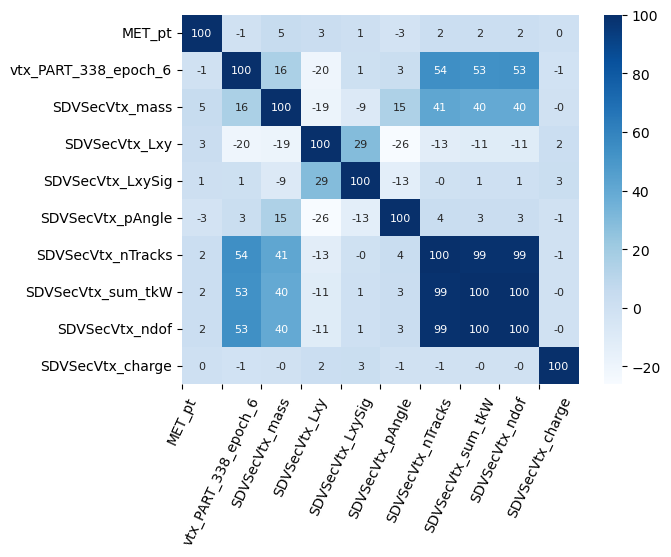

In [4]:
import seaborn as sns
corr_res_scaled = corr_res * 100
s = sns.heatmap(corr_res_scaled, annot=True,cmap='Blues', fmt=".0f", annot_kws={"size": 8})
plt.xticks(range(len(corr_res_scaled)), corr_res_scaled.columns, rotation=65)
plt.show()

# corr on .parquet

In [ ]:
from dask.distributed import Client, LocalCluster
import awkward as ak
import uproot
import dask_awkward as dak
import dask.dataframe as dd
import matplotlib.pyplot as plt
import glob
import fnmatch

patterns = [
    "/eos/vbc/group/cms/ang.li/ParT_datasets/stop*1000*.parquet",
]

# Expand the wildcard paths
files = [f for pat in patterns for f in glob.glob(pat, recursive=True)]

# Check you found files
if not files:
    raise RuntimeError("No Parquet files matched the given patterns.")

# Read them all
df = dak.from_parquet(files)

['vtx_match',
 'vtx_nmatchtks',
 'label_llp',
 'vtx_x',
 'vtx_y',
 'vtx_z',
 'vtx_ntracks',
 'vtx_ndof',
 'vtx_lxy',
 'vtx_lxy_err',
 'vtx_dphi_jet1',
 'vtx_dphi_met',
 'vtx_acollinearity',
 'vtx_E',
 'vtx_pt',
 'vtx_tk_px',
 'vtx_tk_py',
 'vtx_tk_pz',
 'vtx_tk_pt',
 'vtx_tk_eta',
 'vtx_tk_phi',
 'vtx_tk_E',
 'vtx_tk_normchi2',
 'vtx_tk_dxy',
 'vtx_tk_dxyerr',
 'vtx_tk_dz',
 'vtx_tk_dzerr',
 'vtx_tk_nvalidhits',
 'vtx_tk_dphi_jet1',
 'vtx_tk_dphi_met',
 'vtx_tk_dphi_Lvtx',
 'vtx_tk_deta_Lvtx',
 'vtx_tk_dphi_pvtx',
 'vtx_tk_deta_pvtx',
 'vtx_tk_pterr']

In [ ]:
'vtx_tk'

AttributeError: 'DataFrame' object has no attribute 'fields'